In [1]:
import tensorflow as tf
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create the dataset
data_dir = Path('./dataset/rowlet/')

img_height = 200
img_width = 200

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed = 722, # using pokedex number of the hunt
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    shuffle=True
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed = 722, # using pokedex number of the hunt
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    shuffle=True
)

class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 40 files belonging to 2 classes.
Using 32 files for training.
Found 40 files belonging to 2 classes.
Using 8 files for validation.


In [3]:
# Create model
# TODO: mess around and learn more about the layers
# The number of classes may differ depending on the hunt and how it is compiled
# It will either be 2 (target_normal, target_shiny) or 4 (target_normal, target_shiny, not_target_normal, not_target_shiny) 
number_of_classes = len(class_names)

#data_augmentation = tf.keras.models.Sequential()
#data_augmentation.add(tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)))
#data_augmentation.add(tf.keras.layers.RandomRotation(0.1))
#data_augmentation.add(tf.keras.layers.RandomZoom(0.1))

model = tf.keras.models.Sequential()
#model.add(data_augmentation)
model.add(tf.keras.layers.Rescaling(1/.255, input_shape=(img_height, img_width, 3)))
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')) # for mudkip used 32
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')) # for mudkip used 64
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')) # for mudkip used 128
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu')) # for mudkip used 256
model.add(tf.keras.layers.Dense(number_of_classes))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       7

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 32.7709 - accuracy: 0.4375 - val_loss: 16222.3613 - val_accuracy: 0.3750
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 12192.1523 - accuracy: 0.5312 - val_loss: 3920.3457 - val_accuracy: 0.3750
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 2953.6870 - accuracy: 0.5312 - val_loss: 762.8134 - val_accuracy: 0.6250
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 1120.9360 - accuracy: 0.4688 - val_loss: 521.0248 - val_accuracy: 0.6250
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 757.9276 - accuracy: 0.4688 - val_loss: 207.9548 - val_accuracy: 0.6250
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 302.8988 - accuracy: 0.4688 - val_loss: 117.5318 - val_accuracy: 0.3750
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 84.1712 - accuracy: 0.5312 - val_loss: 88.9857 - val_accuracy: 0.3750
Epoch 8/1

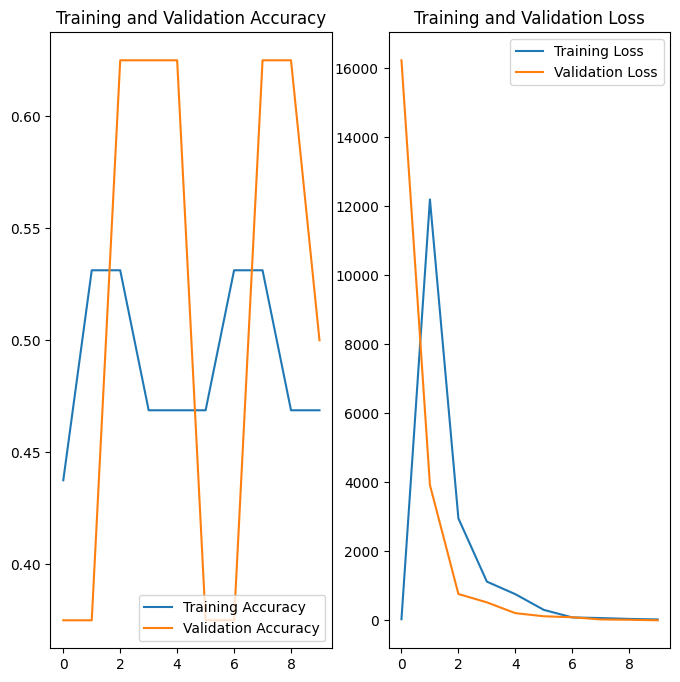

In [4]:
# Train model
epochs = 10
history = model.fit(train_ds, validation_data=valid_ds, epochs=epochs)

# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 54ms/step
This image most likely is target_normal with a 100.00 percent confidence


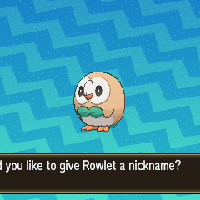

In [27]:
# Test the model with a single image
test_path = Path('./test_imgs/rowlet/12.png')

img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width), keep_aspect_ratio=True)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely is {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100 * np.max(score)))
img

In [30]:
# Test the model in a batch
# TODO: TEST ON LIVE STREAM ARCHIVES
test_path = './test_imgs/rowlet/'
num_normal = 0
num_shiny = 0
normal_score = 0
shiny_score = 0

normal_tests = Path(test_path + 'target_normal')
for file in normal_tests.iterdir():
    img = tf.keras.utils.load_img(file, target_size=(img_height, img_width), keep_aspect_ratio=True)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    if class_names[np.argmax(score)] == 'target_normal':
        normal_score += 1
    print("This image most likely is {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100 * np.max(score)))
    num_normal += 1

shiny_tests = Path(test_path + 'target_shiny')
for file in shiny_tests.iterdir():
    img = tf.keras.utils.load_img(file, target_size=(img_height, img_width), keep_aspect_ratio=True)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    if class_names[np.argmax(score)] == 'target_shiny':
        shiny_score += 1
    print("This image most likely is {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100 * np.max(score)))
    num_shiny += 1


overall_percent = ((shiny_score + normal_score) / (num_normal + num_shiny)) * 100
normal_percent = (normal_score / num_normal) * 100
shiny_percent = (shiny_score / num_shiny) * 100

print(f"Overall Score: {overall_percent}% ({shiny_score + normal_score}/{num_normal + num_shiny})")
print(f"Normal Score: {normal_percent}% ({normal_score}/{num_normal})")
print(f"Shiny Score: {shiny_percent}% ({shiny_score}/{num_shiny})")

1/1 [==============================] - 0s 60ms/step
This image most likely is target_normal with a 100.00 percent confidence
1/1 [==============================] - 0s 60ms/step
This image most likely is target_normal with a 100.00 percent confidence
1/1 [==============================] - 0s 90ms/step
This image most likely is target_normal with a 100.00 percent confidence
1/1 [==============================] - 0s 54ms/step
This image most likely is target_normal with a 100.00 percent confidence
1/1 [==============================] - 0s 43ms/step
This image most likely is target_normal with a 100.00 percent confidence
1/1 [==============================] - 0s 57ms/step
This image most likely is target_normal with a 100.00 percent confidence
1/1 [==============================] - 0s 46ms/step
This image most likely is target_normal with a 78.70 percent confidence
1/1 [==============================] - 0s 49ms/step
This image most likely is target_normal with a 82.54 percent confidence
1/

In [ ]:
# Save the model
model.save('oras_starter_mudkip')